In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import json
import pickle as pkl

from absl import app
#from nasbench import api

import pyreadr
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
path_to_eval_file = "../nasbench/experiments/landscape_with_adj_nb101.json"


In [3]:
with open(path_to_eval_file, 'rb') as filehandle:
        # read the data as bina|ry data stream
        read_data_nb101_evals = json.load(filehandle)

In [4]:
result = pyreadr.read_r('../nasbench/experiments/nasbench_full_landscape.RData')
result = pd.Series(result)

In [5]:
result.keys()

Index(['start_points', '.Random.seed', 'metric_name', 'encsize', 'land.df',
       'fitness_walk', 'epochs', 'min_acc'],
      dtype='object')

In [6]:
fitness_walk = result['fitness_walk']
nasbench_res =  result['land.df']

In [7]:
r1 = fitness_walk.loc[fitness_walk['route'] == 1]
r16 = fitness_walk.loc[fitness_walk['route'] == 16]
#r1

In [8]:
nasbench_res = read_data_nb101_evals['solutions']

In [9]:
perfs_r1 = [nasbench_res[int(idx_ri - 1)]['fitness']['36']['validation_acc'] for idx_ri in r1['path']]
perfs_r16 = [nasbench_res[int(idx_ri - 1)]['fitness']['36']['validation_acc'] for idx_ri in r16['path']]

# Analysing Random Walk routes 1 & 16 on CIFAR-10

In [10]:
# Smoothing the 
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma



In [11]:
len_win = 5
#perfs_r1_ma = movingaverage(perfs_r1, len_win)
#perfs_r16_ma = movingaverage(perfs_r16, len_win)

In [12]:
#np.mean(perfs_r1), np.median(perfs_r1), np.std(perfs_r1)

In [13]:
#np.mean(perfs_r16), np.median(perfs_r16), np.std(perfs_r16)

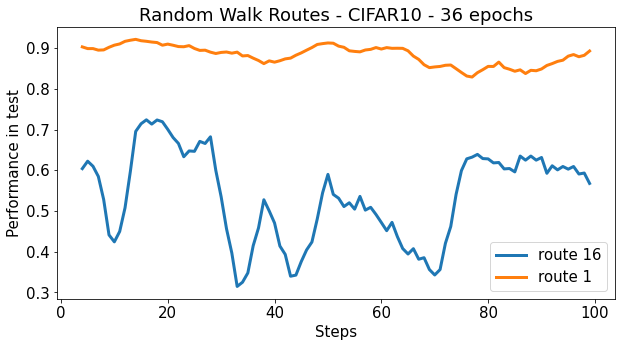

In [14]:
len_win = 5
r16_ma = movingaverage(perfs_r16, len_win)
r1_ma = movingaverage(perfs_r1, len_win)
len_to_remove = len(perfs_r16) - len(r16_ma)

plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(10,5))
plt.plot([i for i in range(len_to_remove, len(r16['fitness']))], r16_ma, label='route 16', linewidth=3)
plt.plot([i for i in range(len_to_remove, len(r16['fitness']))], r1_ma, label='route 1', linewidth=3)
plt.title('Random Walk Routes - CIFAR10 - 36 epochs')
plt.xlabel('Steps')
plt.ylabel('Performance in test')
plt.legend()

# Autocorrelation on Random Walks

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

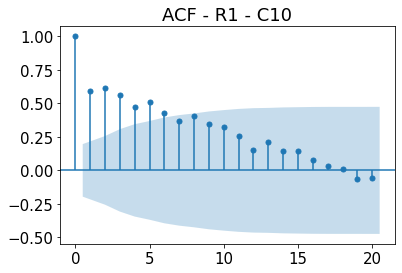

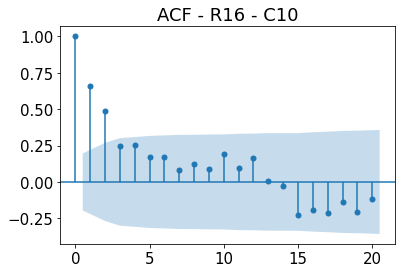

In [16]:
plot_acf(np.array(perfs_r1), lags=20) #len(r1['fitness'])-1)
plt.title('ACF - R1 - C10')
plt.show()

plot_acf(np.array(perfs_r16), lags=20)#len(r16['fitness'])-1)
plt.title('ACF - R16 - C10')
plt.show()

## Autocorellation Length via ACT @ N_lags= 1 

### Collecting all paths first:

In [17]:
dict_routes_perfs = dict()
n_routes = 30
n_steps_per_route = 100

for rt_i in range(n_routes):
    route_ri = fitness_walk.loc[fitness_walk['route'] == rt_i + 1]
    dict_routes_perfs[rt_i] = [nasbench_res[int(idx_ri - 1)]['fitness']['36']['validation_acc'] for idx_ri in route_ri['path']]
    assert len( dict_routes_perfs[rt_i]) == n_steps_per_route

In [18]:
N_lags_ACF = 1

In [19]:
# Autocorelation with step - 1, for Routes 1 & 16
rho_r1_c10 = acf(np.array(perfs_r1), nlags=N_lags_ACF)[1:].mean()
rho_r16_c10 = acf(np.array(perfs_r16), nlags=N_lags_ACF)[1:].mean()

# Autocorellation length  Tau = 1 / Rho(1)
tau_acf_len_r1_c10  = 1 / rho_r1_c10
tau_acf_len_r16_c10  = 1 / rho_r16_c10

# The Smaller the TAU, the rougher the surface
# Plus, R16 is visually rougher than R1
# So, TAU_R16 should be smaller than TAU_R1
#assert tau_acf_len_r16_c10 < tau_acf_len_r1_c10

/local_home/trao_ka/anaconda3/envs/nas_benchmarks/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [20]:
rho_r1_c10, rho_r16_c10

(0.5932274721090498, 0.659398081317443)

In [21]:
tau_acf_len_r16_c10, tau_acf_len_r1_c10, tau_acf_len_r16_c10 < tau_acf_len_r1_c10

(1.5165345916719262, 1.6856940162342573, True)

### Same for all routes in C10

In [22]:
rho_all_routes_c10 = list()
tau_all_routes_c10 = list()
N_lags_ACF = 1

for rt_i in range(n_routes):
    
    # Autocorelation with step - 1, for all routes
    rho_ri = acf(np.array(dict_routes_perfs[rt_i]), nlags=N_lags_ACF)[1:]
    rho_all_routes_c10.append(rho_ri)
    
    
    # Autocorellation length  Tau = 1 / Rho(1)
    tau_acf_len_ri_c10  = 1 / rho_ri
    
    tau_all_routes_c10.append(tau_acf_len_ri_c10)

In [23]:
assert len(rho_all_routes_c10) == n_routes
assert len(tau_all_routes_c10) == n_routes

In [24]:
mean_rho_all_routes_c10 = np.mean(rho_all_routes_c10)
mean_rho_all_routes_c10, 1 / mean_rho_all_routes_c10 

(0.5172907782542937, 1.9331487086909027)